In [120]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
from scipy.optimize import minimize
import pickle
import scipy.stats

In [9]:
with open('..//data//women_hours_empirical', 'rb') as f:
    women_hours = pickle.load(f)
    
with open('..//data//women_salary_mean.pkl', 'rb') as f:
    women_salary = pickle.load(f)

In [108]:
class SalaryProcess:
    
    S_min = 120
    PARAMETERS = {
        'sigma_epsilon'  : 3,
        'alpha' :1.2,
        'omega' : 0.8,
        'eta_G'  : 1.2,
        'eta_Z'  : 1.2,
        'delta'  : 0.9,
    }
    
    def __init__(self, Z=1, G=0, Q=18, sex='women', parameters = PARAMETERS):
        self.Z = Z
        self.G = G
        self.Q = Q
        self.sex = sex
        self.parameters = parameters
        
    def reset(self):
        self.Q = 18
        self.G = 0
        self.Z = 0
        
    def step(self):
        
        if self.Q == 65:
            self.reset()
        else:
            self.Q = self.Q + 1
            self.G = self.parameters['delta'] * self.G +  self.parameters['omega'] * self.H()
            self.Z = self.Z + np.random.normal(0, self.parameters['sigma_epsilon'])
            
        S = self.calc_salary()
        return (S, self.Z, self.G, self.Q)
            
    def H(self):
        return women_hours[self.Q]
        
    def calc_salary(self):
        
        
        S_tilde = self.parameters['eta'] + self.G + self.Z
        S = np.max([S_tilde, self.S_min])
        if pd.isnull(S):
            print(S_tilde, S)
        return S

In [109]:
def calc_mse_women(y_pred):
    y_true = women_salary[18:66]
    y_pred = np.array(y_pred)
    return np.mean((y_true - y_pred)**2)

RESULTS = list()

def obj(x):
    
    parameters = {
        'omega': x[0],
        'delta'  : x[1],
        'eta': x[2]
    }
    
    parameters['sigma_epsilon'] =  3
    parameters['alpha'] = 1.2,
    
    sp = SalaryProcess(parameters = parameters)
    results = list()

    for _ in range((65-18) * 500):
    
        res = sp.step()
        results.append(res)
        
    df = pd.DataFrame(results, columns = ['S', 'log Z', 'G', 'Q'])
    y_pred = np.array(df.groupby('Q').mean()['S'])
    mse = calc_mse_women(y_pred)
    parameters['mse'] = mse
    RESULTS.append(parameters)
    print(int(mse), parameters)
    
    return mse

In [110]:
df = pd.DataFrame(results, columns = ['S', 'log Z', 'G', 'Q'])
y_pred = np.array(df.groupby('Q').mean()['S'])

In [111]:
parameters = list

bounds = [
    (0.05, None),
    (0.05, None),
    (0, None),
]
x0 = (0.4, 0.9, 120)
sol = minimize(obj, x0, bounds=bounds, method='SLSQP')

387 {'omega': 0.4, 'delta': 0.9, 'eta': 120.0, 'sigma_epsilon': 3, 'alpha': (1.2,), 'mse': 387.9154474212132}
378 {'omega': 0.4, 'delta': 0.9, 'eta': 120.0, 'sigma_epsilon': 3, 'alpha': (1.2,), 'mse': 378.18508344665526}
341 {'omega': 0.4000000149011612, 'delta': 0.9, 'eta': 120.0, 'sigma_epsilon': 3, 'alpha': (1.2,), 'mse': 341.37848116201775}
346 {'omega': 0.4, 'delta': 0.9000000149011612, 'eta': 120.0, 'sigma_epsilon': 3, 'alpha': (1.2,), 'mse': 346.6780868917023}
343 {'omega': 0.4, 'delta': 0.9, 'eta': 120.00000001490116, 'sigma_epsilon': 3, 'alpha': (1.2,), 'mse': 343.49202210619643}


/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in square
  after removing the cwd from sys.path.


OverflowError: cannot convert float infinity to integer

In [112]:
print(sol)
#sol.x
RESULTS_DF = pd.DataFrame(RESULTS) 

     fun: 622.8440767362737
     jac: array([-4.90019898e+12,  2.88399273e+11, -5.86675965e+12])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([  0.4,   0.9, 120. ])


In [113]:
RESULTS_DF.loc[RESULTS_DF['mse'].min() == RESULTS_DF['mse']]

,omega,delta,eta,sigma_epsilon,alpha,mse
2,0.4,0.9,120.0,3,"(1.2,)",341.378481


{'omega': 0.4000000149011612, 'delta': 0.9, 'eta': 120.0, 'sigma_epsilon': 3, 'alpha': (1.2,), 'mse': 341.37848116201775}


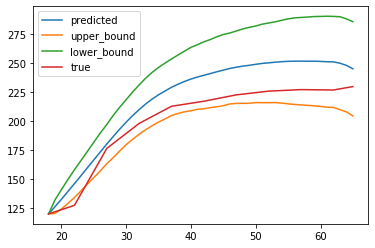

In [114]:
optimal_parameters = RESULTS_DF.loc[RESULTS_DF['mse'].min() == RESULTS_DF['mse']].to_dict(orient='rows')[0]
#sol = [0.39159816, 1.2       , 1.2       , 2.29062806, 0.9 ]
print(optimal_parameters)

sp = SalaryProcess(parameters = optimal_parameters)
results = list()

for _ in range((65-18) * 500):

    res = sp.step()
    results.append(res)

df = pd.DataFrame(results, columns = ['S', 'log Z', 'G', 'Q'])
y_pred = np.array(df.groupby('Q').mean()['S'])
y_std = np.array(df.groupby('Q').std()['S'])


plt.plot(range(18,66),y_pred, label='predicted')
plt.plot(range(18,66),y_pred - 1.96 * y_std, label='upper_bound')
plt.plot(range(18,66),y_pred + 1.96 * y_std, label='lower_bound')

plt.plot(range(18,66),women_salary[18:66], label='true')
plt.legend()

In [115]:
df.loc[df['Q'] == 18]

,S,log Z,G,Q
47,120.0,0.0,0.0,18
95,120.0,0.0,0.0,18
143,120.0,0.0,0.0,18
191,120.0,0.0,0.0,18
239,120.0,0.0,0.0,18
...,...,...,...,...
23279,120.0,0.0,0.0,18
23327,120.0,0.0,0.0,18
23375,120.0,0.0,0.0,18
23423,120.0,0.0,0.0,18


SyntaxError: invalid syntax (<ipython-input-102-cad28b4f5267>, line 1)

param_candidates = list()
for _ in range(300):
    candidate = [
        np.random.uniform(0.1, 1),
        np.random.uniform(0.23, 3.0),
        np.random.uniform(0.5, 1.2),
        np.random.uniform(0.5, 1.2),
        np.random.uniform(0.8, 0.9)
    ]
    param_candidates.append(candidate)

candidates_results = list()
for c in param_candidates:
    mse = obj(c)
    print(mse)
    c.append(mse)
    candidates_results.append(c)

candidates_df = pd.DataFrame(candidates_results, columns = ['sigma_epsilon', 'alpha', 'eta_G', 'eta_Z', 'delta', 'mse'])



candidates_df.loc[candidates_df['mse'] < 900]

best_params = candidates_df.loc[min(candidates_df['mse']) == candidates_df['mse']]
print(best_params)
optimal_parameters = best_params.to_dict() 
optimal_parameters.pop('mse')
optimal_parameters


#sol = [0.39159816, 1.2       , 1.2       , 2.29062806, 0.9 ]
optimal_parameters = {
    'sigma_epsilon' : sol.x[0],
    'alpha' : sol.x[1],
    'eta_G'  : sol.x[2],
    'eta_Z'  : sol.x[3],
    'delta'  : sol.x[4],
}

sp = SalaryProcess(parameters = optimal_parameters)
results = list()

for _ in range((70-18) * 500):

    res = sp.step()
    results.append(res)

df = pd.DataFrame(results, columns = ['S', 'log Z', 'G', 'Q'])
y_pred = np.array(df.groupby('Q').mean()['S'])

plt.plot(range(18,71),y_pred, label='predicted')
plt.plot(women_salary, label='true')
plt.legend()

plt.plot(range(18,71),y_pred, label='predicted')
plt.plot(women_salary, label='true')
plt.legend()

42.376878166064586

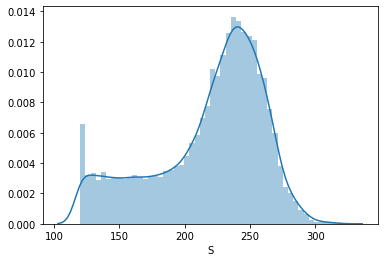

In [119]:
sbn.distplot(df['S'].dropna())
df['S'].isnull().sum()
df['is_na'] = df['S'].isnull()
np.mean(df['S'])
np.std(df['S'])
{
    'mean': np.mean(df['S']),
    'std': np.mean(df['S'])
    'skew': scipy.stats.skew(df['S']),
    'kurtosis': scipy.stats.kurtosis(df['S']),

In [277]:
S = 2.45 +  0.92 * -1.653578 + 0.84 * np.log(8.608565+1)

In [279]:
np.exp(S)

16.934252502677552

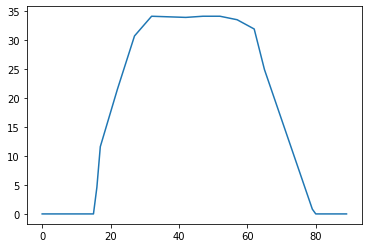

In [9]:
plt.plot(women_hours)

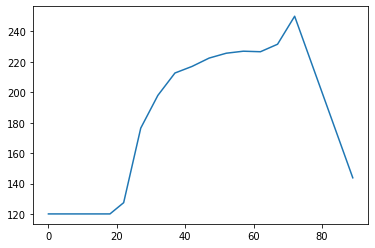

In [93]:
plt.plot(women_salary)

7662.364466233265

In [282]:
np.isnan(None)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''